# **Domain Adaptation and Generalization: Evaluating Model Performance on Unseen Classes**
In this phase of the project, we extend our investigation into domain adaptation by testing the model on the Birds_525_species dataset, focusing specifically on classes that were not present during the training phase on the CUB_200_2011 dataset. This approach allows us to evaluate the model's ability to generalize to unseen classes, a critical aspect of domain adaptation. By doing so, we aim to assess the robustness and adaptability of the model in real-world scenarios where it may encounter new species that were not part of the original training set. Fine-tuning techniques will be employed to further enhance the model's performance on these unseen classes, providing valuable insights into its capacity for domain generalization. The results from this experiment will be instrumental in understanding the effectiveness of the current model architecture and training strategy in handling domain shifts.

In [ ]:
import os
import time
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
from torchvision import transforms, datasets, models

from google.colab import drive

warnings.filterwarnings("ignore")


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Perform domain adaptation using a pre-trained ResNet-18 model, where the goal is to test the model's ability to classify bird species from a new dataset (Birds_525_species) with classes that were not present during the initial training on the CUB_200_2011 dataset. The code first sets up the data transformations and defines classes to drop from the dataset to ensure that only the unseen classes are used for testing. A custom ImageFolder class is implemented to handle the removal of these classes during the data loading process. The model is ***fine-tuned by modifying its final fully connected layer*** to match the number of classes in the new dataset, and ***all layers except the last four are frozen to preserve the learned features***.

In [ ]:
data_dir = "/content/drive/MyDrive/Domain_Adaptation_data"

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

classes_to_drop = ['COCKATOO', 'CRIMSON CHAT', 'CUBAN TODY', 'CUBAN TROGON']

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=datasets.folder.default_loader, classes_to_drop=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader)
        self.classes_to_drop = classes_to_drop
        if classes_to_drop:
            # Map the original class indices to new indices after dropping classes
            self.class_idxs_to_keep = [i for i, class_name in enumerate(self.classes) if class_name not in classes_to_drop]
            self.new_class_to_idx = {i: new_idx for new_idx, i in enumerate(self.class_idxs_to_keep)}

            # Filter classes and adjust the class to index mapping
            self.classes = [class_name for i, class_name in enumerate(self.classes) if i in self.class_idxs_to_keep]
            self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}

            # Filter and remap samples
            self.samples = [(path, self.new_class_to_idx[target]) for path, target in self.samples if target in self.new_class_to_idx]
            self.targets = [self.new_class_to_idx[target] for target in self.targets if target in self.new_class_to_idx]

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

train_dataset = CustomImageFolder(root=os.path.join(data_dir, 'train'), transform=transform, classes_to_drop=classes_to_drop)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomImageFolder(root=os.path.join(data_dir, 'val'), transform=transform, classes_to_drop=classes_to_drop)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.resnet18()
state_dict = torch.load('/content/resnet18_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(in_features=512, out_features=num_classes)

# Freeze all layers except the last 4 layers
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def TabularFormat(epochs, train_cost, train_acc, eval_cost, eval_acc):
    ep = list(range(1, epochs + 1))
    return pd.DataFrame(list(zip(ep, train_cost, train_acc, eval_cost, eval_acc)),
                        columns=['Epoch Value', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])


num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
patience = 5
count = 0


for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    correct_train = 0
    model.train()


    for itr, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), label.to(device)  # Move data to GPU

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()

        predicted = torch.argmax(pred, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    accuracy_train = (100 * correct_train) / total_train
    train_accuracy.append(accuracy_train)
    total_train_loss /= len(train_loader)
    train_loss.append(total_train_loss)

    model.eval()
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for itr, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)  # Move data to GPU

            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            predicted = torch.argmax(pred, dim=1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    accuracy_val = (100 * correct_val) / total_val
    val_accuracy.append(accuracy_val)
    total_val_loss /= len(val_loader)
    val_loss.append(total_val_loss)

    print(f'\nEpoch: {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss:.8f}, '
          f'Train Accuracy: {accuracy_train:.8f}, Val Loss: {total_val_loss:.8f}, '
          f'Val Accuracy: {accuracy_val:.8f}')


    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.8f}")
        torch.save(model.state_dict(), "model_adap.pth")
    else:
        count += 1

    if count == patience:
        print(f'Validation loss did not improve for {patience} consecutive epochs. Stopping training.')
        break

    scheduler.step()

print('Training complete.')


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]



Epoch: 1/50, Train Loss: 4.07380178, Train Accuracy: 7.30158730, Val Loss: 3.15032418, Val Accuracy: 26.98412698
Saving the model state dictionary for Epoch: 1 with Validation loss: 3.15032418


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]



Epoch: 2/50, Train Loss: 2.75252066, Train Accuracy: 30.95238095, Val Loss: 2.15609674, Val Accuracy: 44.12698413
Saving the model state dictionary for Epoch: 2 with Validation loss: 2.15609674


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]



Epoch: 3/50, Train Loss: 1.85274278, Train Accuracy: 52.38095238, Val Loss: 1.81727204, Val Accuracy: 51.11111111
Saving the model state dictionary for Epoch: 3 with Validation loss: 1.81727204


100%|██████████| 20/20 [00:04<00:00,  4.46it/s]



Epoch: 4/50, Train Loss: 1.39653281, Train Accuracy: 62.53968254, Val Loss: 1.49379915, Val Accuracy: 61.58730159
Saving the model state dictionary for Epoch: 4 with Validation loss: 1.49379915


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]



Epoch: 5/50, Train Loss: 1.00368599, Train Accuracy: 74.28571429, Val Loss: 1.27700481, Val Accuracy: 67.30158730
Saving the model state dictionary for Epoch: 5 with Validation loss: 1.27700481


100%|██████████| 20/20 [00:04<00:00,  4.47it/s]



Epoch: 6/50, Train Loss: 0.86229206, Train Accuracy: 80.15873016, Val Loss: 1.24983869, Val Accuracy: 69.52380952
Saving the model state dictionary for Epoch: 6 with Validation loss: 1.24983869


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]



Epoch: 7/50, Train Loss: 0.81144615, Train Accuracy: 81.74603175, Val Loss: 1.20375608, Val Accuracy: 69.84126984
Saving the model state dictionary for Epoch: 7 with Validation loss: 1.20375608


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]



Epoch: 8/50, Train Loss: 0.75575301, Train Accuracy: 82.69841270, Val Loss: 1.27919788, Val Accuracy: 66.34920635


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]



Epoch: 9/50, Train Loss: 0.70616677, Train Accuracy: 86.34920635, Val Loss: 1.09576105, Val Accuracy: 73.01587302
Saving the model state dictionary for Epoch: 9 with Validation loss: 1.09576105


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]



Epoch: 10/50, Train Loss: 0.72159799, Train Accuracy: 83.17460317, Val Loss: 1.07998322, Val Accuracy: 70.15873016
Saving the model state dictionary for Epoch: 10 with Validation loss: 1.07998322


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]



Epoch: 11/50, Train Loss: 0.67595352, Train Accuracy: 86.03174603, Val Loss: 1.13280267, Val Accuracy: 72.06349206


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]



Epoch: 12/50, Train Loss: 0.66719714, Train Accuracy: 86.98412698, Val Loss: 1.27120228, Val Accuracy: 69.20634921


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]



Epoch: 13/50, Train Loss: 0.66957152, Train Accuracy: 87.14285714, Val Loss: 1.11164818, Val Accuracy: 72.69841270


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]



Epoch: 14/50, Train Loss: 0.74069705, Train Accuracy: 83.80952381, Val Loss: 1.16686417, Val Accuracy: 73.01587302


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]



Epoch: 15/50, Train Loss: 0.67759093, Train Accuracy: 84.92063492, Val Loss: 1.10301306, Val Accuracy: 72.06349206
Validation loss did not improve for 5 consecutive epochs. Stopping training.
Training complete.


In [ ]:
df = TabularFormat(num_epochs, train_loss, train_accuracy, val_loss, val_accuracy)
df

,Epoch Value,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,1,4.073802,7.301587,3.150324,26.984127
1,2,2.752521,30.952381,2.156097,44.126984
2,3,1.852743,52.380952,1.817272,51.111111
3,4,1.396533,62.539683,1.493799,61.587302
4,5,1.003686,74.285714,1.277005,67.301587
5,6,0.862292,80.158730,1.249839,69.523810
6,7,0.811446,81.746032,1.203756,69.841270
7,8,0.755753,82.698413,1.279198,66.349206
8,9,0.706167,86.349206,1.095761,73.015873
9,10,0.721598,83.174603,1.079983,70.158730


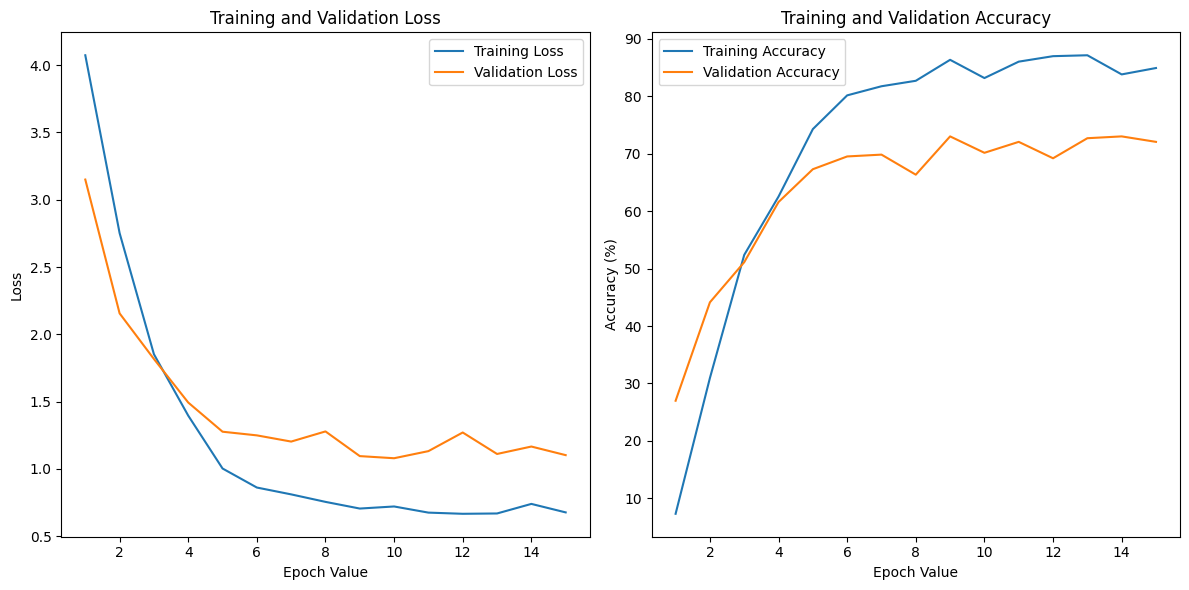

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df['Epoch Value'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch Value'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch Value')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(df['Epoch Value'], df['Training Accuracy'], label='Training Accuracy')
plt.plot(df['Epoch Value'], df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#**Conclusion:**
The model shows effective learning and adaptation to the new domain, with both training and validation losses decreasing significantly. Training accuracy surpasses 80%, while validation accuracy stabilizes around 70%, indicating good generalization with potential for further fine-tuning.

# **TESTING**

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data_dir = "/content/drive/MyDrive/Domain_Adaptation_data/testing"

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=datasets.folder.default_loader, classes_to_drop=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader)
        self.classes_to_drop = classes_to_drop
        if classes_to_drop:
            self.class_idxs_to_keep = [i for i, class_name in enumerate(self.classes) if class_name not in classes_to_drop]
            self.classes = [class_name for class_name in self.classes if class_name not in classes_to_drop]
            self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}
            self.samples = [(path, self.class_to_idx[self.classes[target]]) for path, target in self.samples if target in self.class_idxs_to_keep]
            self.targets = [self.class_to_idx[self.classes[target]] for target in self.targets if target in self.class_idxs_to_keep]

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

test_dataset = CustomImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet18(pretrained=False)
num_classes = len(test_dataset.classes)
model.fc = nn.Linear(in_features=512, out_features=num_classes)
state_dict = torch.load('/content/model_adap.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8039


In [ ]:
accuracy_percentage = accuracy* 100
print(f'Test Accuracy: {accuracy_percentage:.2f}%')

Test Accuracy: 80.39%


In [ ]:
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

                      precision    recall  f1-score   support

       ABBOTTS BOOBY       0.49      0.24      0.32       180
           ALBATROSS       0.54      0.82      0.65       132
AZURE BREASTED PITTA       0.93      0.97      0.95       141
          BLACK BAZA       0.76      0.75      0.75       156
           BLUE COAU       0.88      0.82      0.85       165
        CAPUCHINBIRD       0.85      0.96      0.90       133
           CASSOWARY       0.83      0.72      0.77       160
                CROW       0.67      0.75      0.71       163
    DAURIAN REDSTART       0.77      0.80      0.79       146
              DUNLIN       0.80      0.93      0.86       190
          EARED PITA       0.82      0.93      0.87       154
                 EMU       0.74      0.68      0.71       163
     EURASIAN MAGPIE       0.85      0.68      0.76       154
   FRILL BACK PIGEON       0.93      0.63      0.75       209
        GO AWAY BIRD       0.57      0.73      0.64       131
       

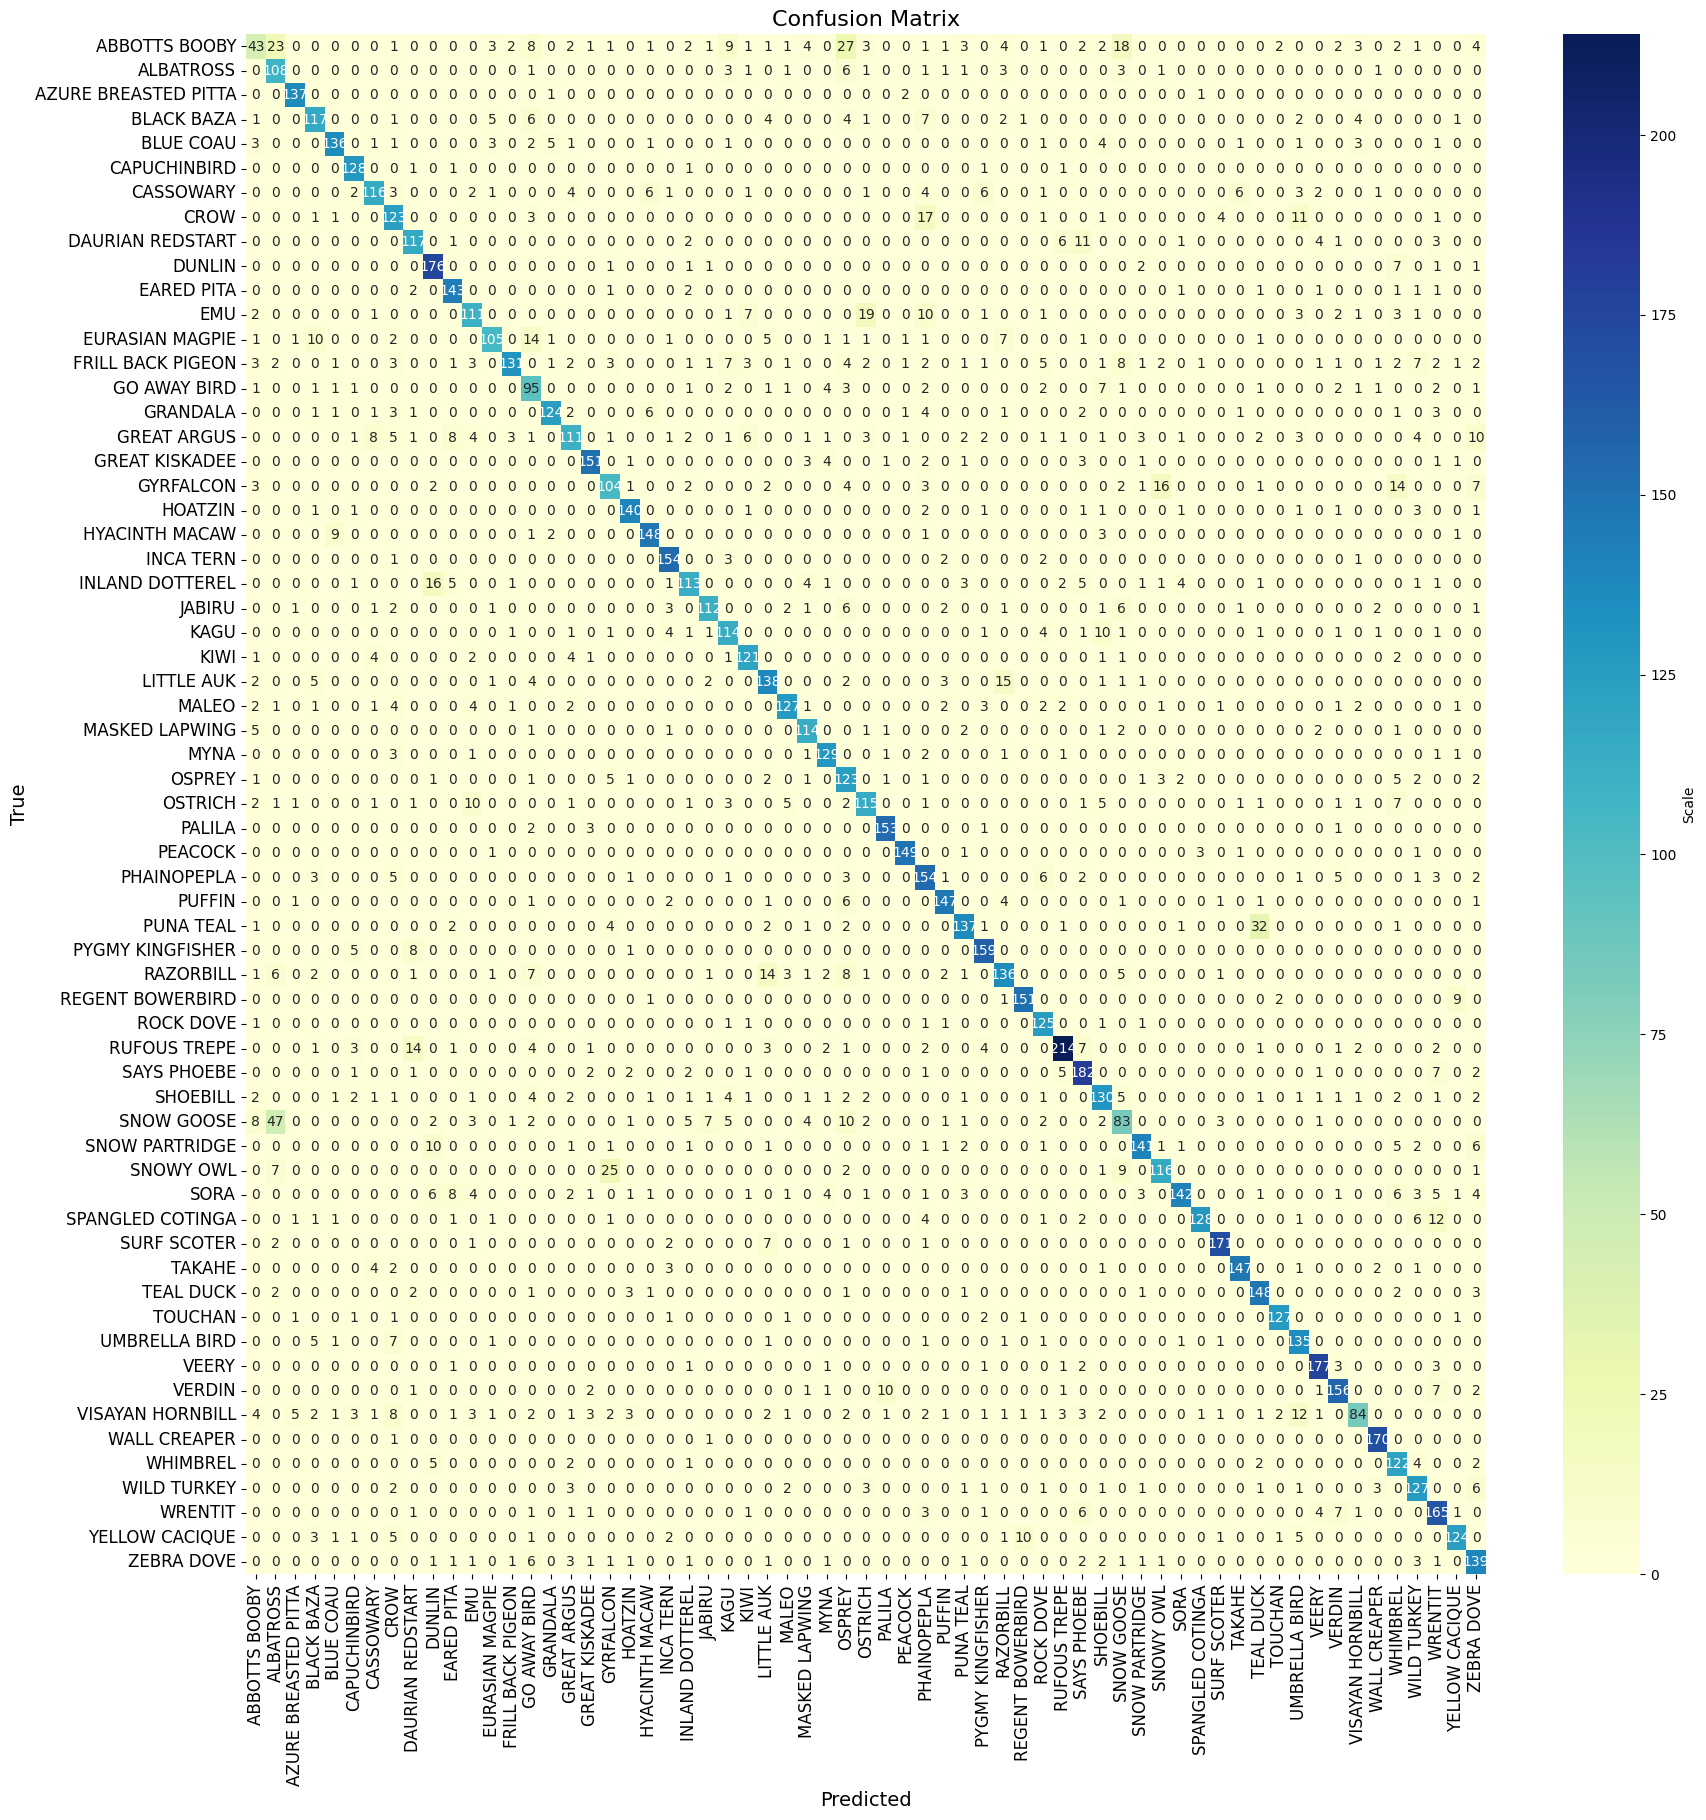

In [ ]:
def plot_confusion_matrix(model, test_loader, class_names, figsize=(20, 20), fontsize=12):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.xlabel('Predicted', fontsize=fontsize + 2)
    plt.ylabel('True', fontsize=fontsize + 2)
    plt.title('Confusion Matrix', fontsize=fontsize + 4)
    plt.show()
plot_confusion_matrix(model, test_loader, test_dataset.classes)

This confusion matrix shows the performance of a multi-class classification model across 63 bird species. The model has high accuracy, as indicated by the strong diagonal, with most classes being correctly predicted. Misclassifications are minimal, but there are some off-diagonal entries indicating confusion between specific classes, such as "Eared Pitta" and "Hyacinth Macaw." Overall, the model performs well, but some species pairs show slight prediction errors.

# **Conclusion**
In this project, we explored the effectiveness of several **convolutional neural network (CNN) architectures—ResNet18, VGG16,** and **MobileNet**—trained on the CUB_200_2011 dataset and evaluated their performance on the Birds_525_species dataset. Our approach involved two key phases:

- **Evaluation on Common Classes:**We initially tested the models on classes that were present in both the training and testing datasets. This step allowed us to assess how well each architecture generalizes to known classes across different datasets. The results provided insights into the models' robustness and ability to maintain performance when faced with variations in the dataset.

- **Domain Adaptation for Unseen Classes:** We subsequently focused on evaluating the models' ability to handle classes not seen during training. This domain adaptation phase was crucial in understanding how well the models generalize to new, previously unseen categories. We employed fine-tuning techniques to improve the models' adaptability and performance on these novel classes.

Overall, the results highlighted the strengths and limitations of each architecture in both scenarios.The findings underscore the importance of selecting appropriate models and fine-tuning strategies for effective domain adaptation.

# **Future Work**
Based on the outcomes of this project, several avenues for future research and improvement can be explored:

- **Enhanced Fine-Tuning Techniques:** Investigating more advanced fine-tuning techniques, such as learning rate schedules, adaptive optimizers, or layer-wise fine-tuning, could further enhance the models' performance on unseen classes.

- **Integration of Additional Data:** Incorporating supplementary datasets or leveraging data augmentation strategies might improve the models' generalization capabilities and robustness against domain shifts.

- **Exploration of Transfer Learning:** Experimenting with different transfer learning strategies, such as using pre-trained models on broader datasets, could provide insights into their effectiveness in diverse domain adaptation scenarios.

- **Benchmarking with Other Architectures:** Evaluating additional architectures, including state-of-the-art models or those designed specifically for domain adaptation, could offer new perspectives on achieving better performance.

- **Evaluation Metrics:** Expanding the evaluation metrics to include domain-specific metrics, such as domain discrepancy measures or domain adaptation benchmarks, might provide a more comprehensive understanding of the models' adaptability.

By addressing these areas, future work can build upon the current findings and contribute to more effective domain adaptation solutions in computer vision.